In [40]:
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt
from scipy import linalg as sla
import itertools as iter
import sys
import random as rand
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver
from qiskit_nature.second_q.mappers import JordanWignerMapper, LogarithmicMapper
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.algorithms.optimizers import SLSQP
from qiskit.primitives import Estimator
from qiskit_nature.second_q.algorithms import GroundStateEigensolver, QEOM
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD
from qiskit import *
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, AncillaRegister, transpile
from qiskit.tools.visualization import circuit_drawer
from qiskit.quantum_info import state_fidelity, Statevector, Operator, Pauli, SparsePauliOp
from qiskit import Aer
from qiskit.primitives import Estimator
from qiskit.algorithms.optimizers import SPSA
from qiskit.circuit.library import TwoLocal, PauliEvolutionGate
from qiskit.algorithms import TimeEvolutionProblem, RealTimeEvolver, RealEvolver, SciPyRealEvolver, VarQRTE
from qiskit.algorithms.time_evolvers import TrotterQRTE
from qiskit.circuit import Parameter, ControlledGate, Gate
from qiskit.extensions import UnitaryGate
from qiskit.converters import circuit_to_gate
from qiskit.synthesis import SuzukiTrotter, LieTrotter, MatrixExponential

## Dihydrogen Molecule (Electronic Hamiltonian):

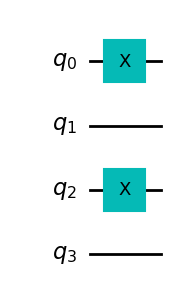

In [18]:
# Prepare a Dihydrogen Molecule within its second_q_op structure:

h2_driver = PySCFDriver(
    atom = "H 0 0 0; H 0 0 0.735",
    basis = "sto3g",
    charge = 0,
    spin = 0,
    unit = DistanceUnit.ANGSTROM,
)

# Create Problem instance for dihydrogen molecule:

diHydro_prob = h2_driver.run()

# Generate the Electronic Hamiltonian for Dihydrogen:

h2_Hamiltonian = diHydro_prob.hamiltonian
coefficients = h2_Hamiltonian.electronic_integrals

# Apply second-quantization transformation to Electronic Hamiltonian:

sq_h2_op = h2_Hamiltonian.second_q_op()

# This Second-Quantized Electronic Hamiltonian does NOT contain the nuclei repulsive/attractive terms!

# Set up Jordan-Wigner Mapper/Transformer to bring Second Quantized Hamiltonian into qubit space:

jw_map = JordanWignerMapper()

# Apply mapper to Second Quantized Electronic Hamiltonian:

qubit_h2_Ham = jw_map.map(sq_h2_op)

# Obtain the initial state from which to apply the time evolution of the converted Hamiltonian:

HartreeFock_initial = HartreeFock(diHydro_prob.num_spatial_orbitals, diHydro_prob.num_particles, jw_map,)

# Draw the initial state to evolve:

HartreeFock_initial.draw('mpl')

In [19]:
# Select an appropriate order, accuracy, evolution time, time step size, and Trotter number for the qDRIFT Protocol:

'''These are the general control parameters for the Electronic Hamiltonian. Refer to these (and change) these variables to experiment with various random unitary configurations'''

final_time = 50 # Termination time of real time evolution.
Trotter_Num = 10 # Trotter number associated with Product Formula construction.
time_step = 0.1 # Time step increment for sampling purposes. Does not affect the Product Formula construction.
epsilon = 1.6 * 10**(-3) # Select a desired chemical accuracy for simulation purposes.

evo_time_range = np.arange(0, final_time, time_step) # Define a time evolution range that will scale to the plotted Hamiltonian evolution.


In [93]:
# Define a function "gen_essentials" to generate all stochastic variables/sets necessary to construct the cumulative unitary operator for large repetitions:

def gen_essentials(hamiltonian):

    selection = range(1, 2**hamiltonian.num_qubits)

    print(selection)

    weights_list = rand.sample(selection, 2**hamiltonian.num_qubits - 1)

    print(weights_list)

    lamb = sum(weights_list)

    print(lamb)

    prob_dist = [x / lamb for x in weights_list]

    print("The generated probability weight list is: " + str(prob_dist))

    qDRIFT_triple = (lamb, prob_dist, weights_list)

    return (qDRIFT_triple)

In [49]:
# Define a function to randomly pick a unitary operator:

def pick(summand_list, prob_dist):

    print(len(summand_list))
    print(len(prob_dist))

    bucket = rand.choices(summand_list, weights=prob_dist, cum_weights=None, k=1)

    return(bucket)

In [22]:
# Generate the evolved state vectors and cache their associated coefficients:

def state_generation(hamiltonian, time_range, initial_state):

    state_coefficients = np.empty(shape=(2**(hamiltonian.num_qubits), len(time_range)), dtype=tuple)

    exact_energies = list()

    exact_initial = initial_state.to_instruction()

    exact_initial = Statevector.from_instruction(exact_initial)

    m_exp = MatrixExponential()
    

    for k in range(len(time_range)):

        exact_unitary_Exp = PauliEvolutionGate(hamiltonian, time=time_range[k], synthesis= m_exp)

        template_Exp = QuantumCircuit(initial_state.width())

        template_Exp.compose(exact_unitary_Exp, range(initial_state.width()))

        evolved_state_Exp = exact_initial.evolve(exact_unitary_Exp)

        exact_energies.append(evolved_state_Exp.expectation_value(hamiltonian))

        for j in range(len(evolved_state_Exp.data)):

            coefficients_re = np.real(evolved_state_Exp.data[j])
            coefficients_im = np.imag(evolved_state_Exp.data[j])

            coefficients_pair = (coefficients_re, coefficients_im)
            
            state_coefficients[j][k] = coefficients_pair

    pair = (state_coefficients, exact_energies)

    return(pair)

In [23]:
# Define a function to identify states that have some excitation/probability of being measured:

def identify_states(state_list, hamiltonian, time_range):

   #print("Arrived at identify_states function!")

    meaningful_states = list()

    bool_states = [False] * 2**(hamiltonian.num_qubits)

    for i in range(len(time_range)):

        for j in range(2**(hamiltonian.num_qubits)):

            pair = state_list[j][i]

            if (pair[0] != 0 and pair[1] != 0j):
                bool_states[j] = True
                
    for k in range(len(bool_states)):
        if (bool_states[k] == True):
            meaningful_states.append(k)

    return(meaningful_states)

In [91]:
# Define a function to compose the qDRIFT circuit via the appropriate protocol:

def qDRIFT_protocol(hamiltonian, initial_state, time_range, accuracy):
    
    qDRIFT_energies = list()
    estimator = Estimator()
    exp_summand = list()
    evo_time = Parameter('t')

    qDRIFT_coefficients = np.empty(shape=(2**(hamiltonian.num_qubits), len(time_range)), dtype=tuple)

    # Obtain the essential variables (probability distribution and cumulative weight of summand coefficients):

    qDRIFT_pair = gen_essentials(hamiltonian)

    # Obtain the selection count necessary to construct the equivalent unitary list:

    N = np.ceil((2 * qDRIFT_pair[0]**2 * time_range[-1]**2) / (accuracy))
    temp_N = 2

    # Partition each qubit_h2_Ham list object into separate list of exponentiated summands:

    print("The following are the summands of the Hamiltonian: ")

    print(hamiltonian)

    for i in range(0, len(hamiltonian)):
        exp_summand.append(PauliEvolutionGate(hamiltonian[i], time=(qDRIFT_pair[0] *evo_time) / temp_N))

    # Perform Selection algorithm to construct the V_list operator:

    V_list = list()

    #for i in range(0, int(N)):
    for i in range(0, temp_N):
        V_list.append(pick(exp_summand, qDRIFT_pair[1]))

    # Append V_list gates to template circuit:

    Rand_circuit = QuantumCircuit(initial_state.width())

    for i in range(len(V_list)):
        Rand_circuit.append(V_list[i][0], range(initial_state.width()))

    for j in range(temp_N):
        Rand_circuit.compose(Rand_circuit, range(Rand_circuit.width()))

    qDRIFT_circ = initial_state.compose(Rand_circuit, range(initial_state.width()))

    # Prepare an estimator to measure expectation value of Hamiltonian:

    for k in range(len(time_range)):

        result = estimator.run(qDRIFT_circ, hamiltonian, parameter_values=[time_range[k]]).result()
        
        qDRIFT_energies.append(np.real(result.values))
        
        qDRIFT_circ_copy = qDRIFT_circ.assign_parameters({evo_time: time_range[k]}, inplace = False)

        qDRIFT_op = Operator.from_circuit(qDRIFT_circ_copy)

        qDRIFT_instruct = Operator.to_instruction(qDRIFT_op)

        qDRIFT_vector = Statevector.from_instruction(qDRIFT_instruct)

        for j in range(len(qDRIFT_vector.data)):

            coefficients_re = np.real(qDRIFT_vector.data[j])
            coefficients_im = np.imag(qDRIFT_vector.data[j])

            coefficients_pair = (coefficients_re, coefficients_im)
            
            qDRIFT_coefficients[j][k] = coefficients_pair

    qDRIFT_tuple = (qDRIFT_circ, qDRIFT_energies, qDRIFT_coefficients, temp_N, qDRIFT_pair)

    return (qDRIFT_tuple)

In [79]:
# Invoke the qDRIFT Protocol:

qDRIFT_result = qDRIFT_protocol(qubit_h2_Ham, HartreeFock_initial, evo_time_range, epsilon)

'''Warning: Given the nature of qDRIFT, accurate approximation leads to exponentially large gate complexity! Be careful when drawing!'''

#qDRIFT_tuple[0].draw()

range(1, 16)
[4, 15, 11, 13, 10, 7, 9, 6, 2, 5, 1, 3, 8, 12, 14]
120
The generated probability weight list is: [0.03333333333333333, 0.125, 0.09166666666666666, 0.10833333333333334, 0.08333333333333333, 0.058333333333333334, 0.075, 0.05, 0.016666666666666666, 0.041666666666666664, 0.008333333333333333, 0.025, 0.06666666666666667, 0.1, 0.11666666666666667]
15
15
15
15


'Warning: Given the nature of qDRIFT, accurate approximation leads to exponentially large gate complexity! Be careful when drawing!'

In [26]:
# Obtain a list of states that are meaningful to plot (i.e., have some probability of being measured):

h2_states = identify_states(qDRIFT_result[2], qubit_h2_Ham, evo_time_range)

print(h2_states)

# Obtain a list of coefficients that correspond to meaningful states: 

h2_coefficients_re_approx = np.zeros(shape=(2**(qubit_h2_Ham.num_qubits), len(evo_time_range)))
h2_coefficients_im_approx = np.zeros(shape=(2**(qubit_h2_Ham.num_qubits), len(evo_time_range)))

for i in range(2**qubit_h2_Ham.num_qubits):

    for j in range(len(evo_time_range)):

        real = qDRIFT_result[2][i][j][0]
        imag = qDRIFT_result[2][i][j][1]

        h2_coefficients_re_approx[i][j] = real 
        h2_coefficients_im_approx[i][j] = imag

[5, 10]


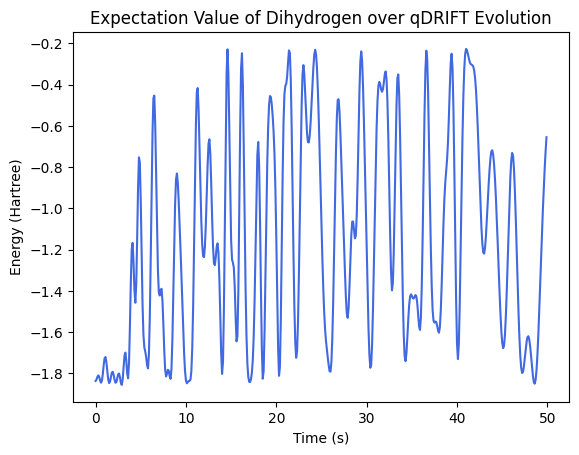

In [31]:
# Graph the energy variation over the specified time interval:

plt.plot(evo_time_range, qDRIFT_result[1], color="royalblue")
plt.xlabel("Time (s)")
plt.ylabel("Energy (Hartree)")
plt.title("Expectation Value of Dihydrogen over qDRIFT Evolution")
plt.savefig('./Plots/qDRIFT/Expectation Values/h2_'+ str(evo_time_range[-1]) + 's_.png')

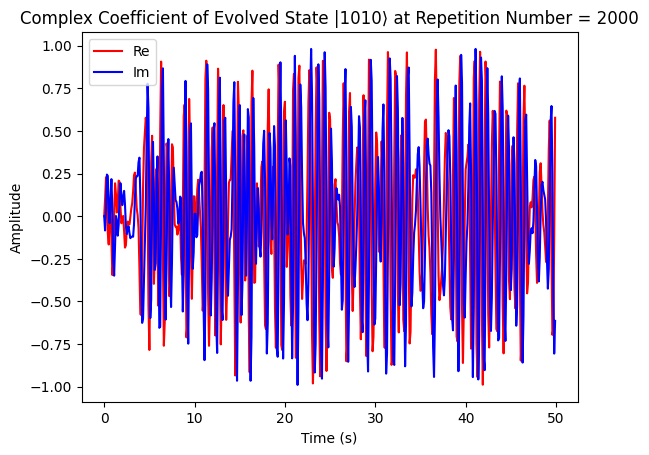

In [33]:
# Plot the evolved state coefficients:

plt.plot(evo_time_range, h2_coefficients_re_approx[h2_states[1]], color = 'r', label = "Re")
plt.plot(evo_time_range, h2_coefficients_im_approx[h2_states[1]], color = 'b', label = "Im")
plt.title('Complex Coefficient of Evolved State |' + format(h2_states[1], '0' + str(qubit_h2_Ham.num_qubits) + 'b') + '⟩ at Repetition Number = ' + str(qDRIFT_result[3]))
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend(loc="best")
plt.savefig('./Plots/qDRIFT/States/Coefficient_h2_'+ format(h2_states[1], '0' + str(qubit_h2_Ham.num_qubits) + 'b') + '_' + str(qDRIFT_result[3]) + 'r.png' )


### Trotter Error Bound:

In [30]:
# Calculate the upper bounded Trotter error of the qDRIFT configuration:

h2_error = (len(qubit_h2_Ham)**2 * (max(qDRIFT_result[4]))**2 * (final_time)**2 * np.exp((max(qDRIFT_result[4]) * final_time * len(qubit_h2_Ham))/qDRIFT_result[3])) / 2* qDRIFT_result[3]

print("The associate upper bound Trotter Error of this qDRIFT configuration is: O(" + str(h2_error) + ")")

The associate upper bound Trotter Error of this qDRIFT configuration is: O(35092273509959.145)


### Necessary Gate Count for Constant Accuracy:

In [63]:
#N = np.ceil((2 * qDRIFT_pair[0]**2 * time_range[-1]**2) / (accuracy))

### Relationship Plots

In [ ]:
# Gate Count vs. Order:

In [ ]:
# Trotter Number vs. Order:

### Via Standard Methods:

In [ ]:
# Obtain a list of states that are meaningful to plot (i.e., have some probability of being measured):

exact_attri = state_generation(qubit_h2_Ham, evo_time_range, initial_state)

hb_states = identify_states(exact_attri[0], qubit_hb_Ham, hb_evo_time_range)

# Obtain a list of coefficients that correspond to meaningful states: 

hb_coefficients_re_ex = np.zeros(shape=(2**(qubit_hb_Ham.num_qubits), len(hb_evo_time_range)))
hb_coefficients_im_ex = np.zeros(shape=(2**(qubit_hb_Ham.num_qubits), len(hb_evo_time_range)))

for i in range(2**qubit_hb_Ham.num_qubits):

    for j in range(len(evo_time_range)):

        real = exact_attri[0][i][j][0]
        imag = exact_attri[0][i][j][1]

        hb_coefficients_re_ex[i][j] = real
        hb_coefficients_im_ex[i][j] = imag
        

### Heisenberg Model (Lattice-based):

In [66]:
from math import pi
from qiskit_nature.second_q.hamiltonians.lattices import(
    BoundaryCondition,
    HyperCubicLattice,
    Lattice,
    LatticeDrawStyle,
    LineLattice,
    SquareLattice,
    TriangularLattice,
)
from qiskit_nature.second_q.hamiltonians import FermiHubbardModel, HeisenbergModel, IsingModel
from qiskit_nature.second_q.mappers import LinearMapper
from qiskit.circuit.library import EfficientSU2

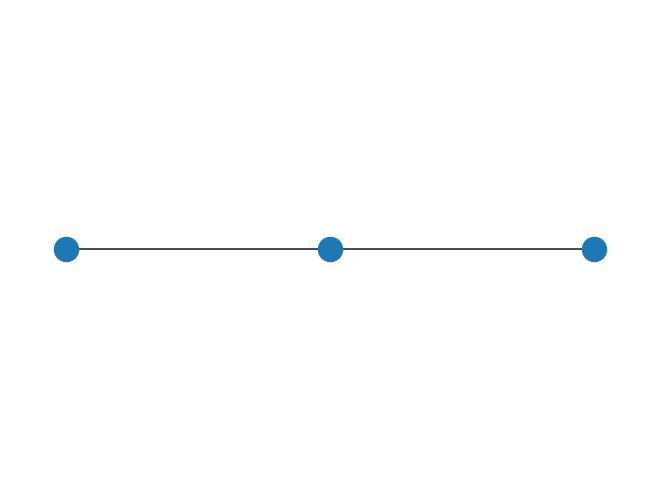

In [67]:
# Instantiate Line_Lattice for Hamiltonian generation:

line_lattice = LineLattice(num_nodes=3, boundary_condition=BoundaryCondition.OPEN)
heisenberg_model = HeisenbergModel(line_lattice, (1.0, 1.0, 1.0), (0.0, 0.0, 1.0))
line_lattice.draw()

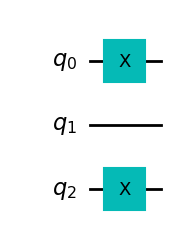

In [87]:
# Obtain Second Quantized operator of Heisenberg Model Hamiltonian:

hb_Ham = heisenberg_model.second_q_op()

# Invoke Linear Mapper/Transformation to bring Hamiltonian into Qubit Space:

log_map = LogarithmicMapper()

qubit_hb_Ham = log_map.map(hb_Ham.simplify())

# Construct appropriate ansatz for Variational Time Evolution:

hb_initial_state = QuantumCircuit(qubit_hb_Ham.num_qubits)
hb_initial_state.x(range(0, qubit_hb_Ham.num_qubits, 2))

hb_initial_state.draw('mpl') # Known as the Néel state of a Lattice-based Hamiltonian

In [88]:
# Select an appropriate order, accuracy, evolution time, time step size, and Trotter number for the Product Formula:

'''These are the general control parameters for the Electronic Hamiltonian. Refer to these (and change) these variables to experiment with various product formulas'''

hb_PF_order = 1 # Order of Product Formula.
hb_final_time = 50 # Termination time of real time evolution.
hb_Trotter_Num = 1 # Trotter number associated with Product Formula construction.
hb_time_step = 0.1 # Time step increment for sampling purposes. Does not affect the Product Formula construction.
hb_epsilon = 1.6 * 10**-3 # Select a desired chemical accuracy for simulation purposes.

hb_evo_time_range = np.arange(0, hb_final_time, hb_time_step) # Define a time evolution range that will scale to the plotted Hamiltonian evolution.

In [92]:
# Invoke the qDRIFT Protocol:

qDRIFT_result_heisenberg = qDRIFT_protocol(qubit_hb_Ham, hb_initial_state, hb_evo_time_range, hb_epsilon)

'''Warning: Given the nature of qDRIFT, accurate approximation leads to esxponentially large gate complexity! Be careful when drawing!'''

#qDRIFT_tuple[0].draw()

range(1, 8)
[3, 4, 6, 2, 7, 1, 5]
28
The generated probability weight list is: [0.10714285714285714, 0.14285714285714285, 0.21428571428571427, 0.07142857142857142, 0.25, 0.03571428571428571, 0.17857142857142858]
The following are the summands of the Hamiltonian: 
0.25 * IXX
+ 0.25 * IYY
+ 0.25 * IZZ
+ 0.25 * XXI
+ 0.25 * YYI
+ 0.25 * ZZI
+ 0.5 * IIZ
+ 0.5 * IZI
+ 0.5 * ZII
9
7


ValueError: The number of weights does not match the population